In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import torch
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import torch.onnx
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from tqdm import tqdm

multiclass_categories = {
    0: 'NV',
    1: 'MEL',
    2: 'BCC',
    3: 'AKIEC',
    4: 'DF',
    5: 'VASC'
}

class MobileNetV3(nn.Module):
    def __init__(self, num_classes):
        super(MobileNetV3, self).__init__()
        self.model = models.mobilenet_v3_small(pretrained=True)
        in_features = self.model.classifier[3].in_features
        self.model.classifier[3] = nn.Linear(in_features, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.model(x)
        x = self.softmax(x)
        return x

model = MobileNetV3(num_classes=6)

model.load_state_dict(torch.load("/content/drive/My Drive/ai&vis/best_model.pth", map_location=torch.device('cpu')))
model.eval()



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 67.2MB/s]
<ipython-input-2-9b29638702b9>:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the defa

MobileNetV3(
  (model): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
            (activation): ReLU()
            (scale_activation): Hardsigmoid()
          )
          (2): Conv2d

Class-specific uncertainty for class NV: 0.7496970295906067
Class-specific uncertainty for class MEL: 0.7970788478851318
Class-specific uncertainty for class BCC: 0.8633060455322266
Class-specific uncertainty for class AKIEC: 0.8633060455322266
Class-specific uncertainty for class DF: 0.8633060455322266
Class-specific uncertainty for class VASC: 0.8633060455322266


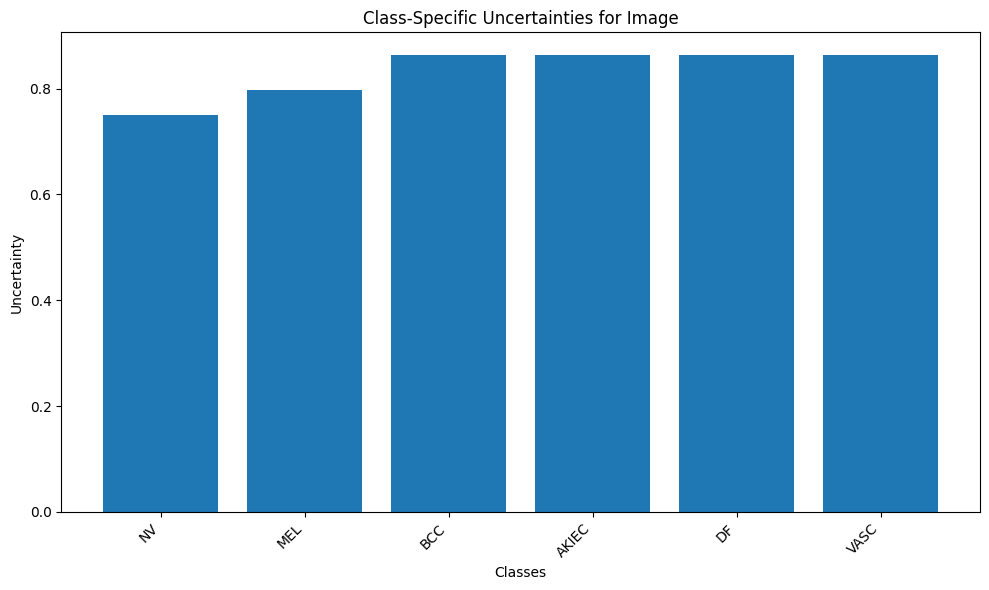

sum of (1-uncertainties):  0.9999999403953552


In [3]:
import torch
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms

def class_specific_uncertainty(model, image_tensor, class_index):
  """
  Calculates the class-specific uncertainty for a given image and class.

  Args:
      model: The trained PyTorch model.
      image_tensor: The input image tensor.
      class_index: The index of the class for which to calculate uncertainty.

  Returns:
      The class-specific uncertainty (float).
  """
  with torch.no_grad():
      output = model(image_tensor)
      probabilities = torch.softmax(output, dim=1)

      # Get the predicted probability for the specified class
      class_probability = probabilities[0, class_index]

      # Calculate uncertainty as 1 - probability
      uncertainty = 1 - class_probability
  return uncertainty.item()


image_path = "/content/drive/My Drive/ai&vis/images_subset_large/ISIC_0024355.jpg"


# Load and preprocess the image
image = Image.open(image_path).convert('RGB') # Open the image using PIL
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
image_tensor = transform(image).unsqueeze(0) # Apply transforms and add batch dimension

testcount = 0
uncertainties = []

for class_index in range(6):
  uncertainty = class_specific_uncertainty(model, image_tensor, class_index)

  print(f"Class-specific uncertainty for class {multiclass_categories[class_index]}: {uncertainty}")
  testcount += 1-uncertainty
  uncertainties.append(uncertainty)

# Plotting

plt.figure(figsize=(10, 6))
plt.bar(multiclass_categories.values(), uncertainties)
plt.xlabel("Classes")
plt.ylabel("Uncertainty")
plt.title("Class-Specific Uncertainties for Image")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

print("sum of (1-uncertainties): ", testcount)

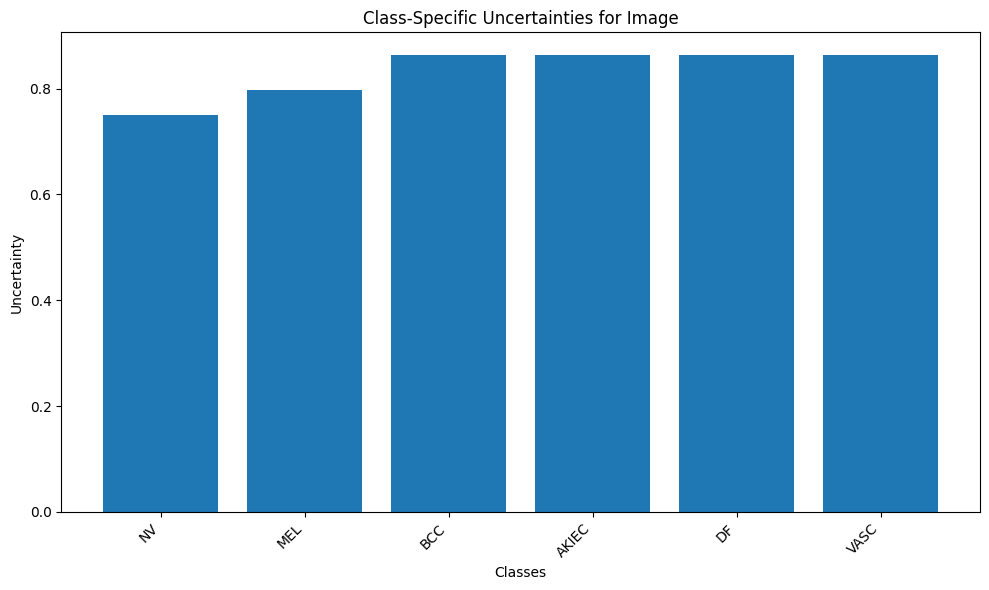

In [4]:

uncertainties = []
for class_index in range(6):
    uncertainty = class_specific_uncertainty(model, image_tensor, class_index)
    uncertainties.append(uncertainty)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(multiclass_categories.values(), uncertainties)
plt.xlabel("Classes")
plt.ylabel("Uncertainty")
plt.title("Class-Specific Uncertainties for Image")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

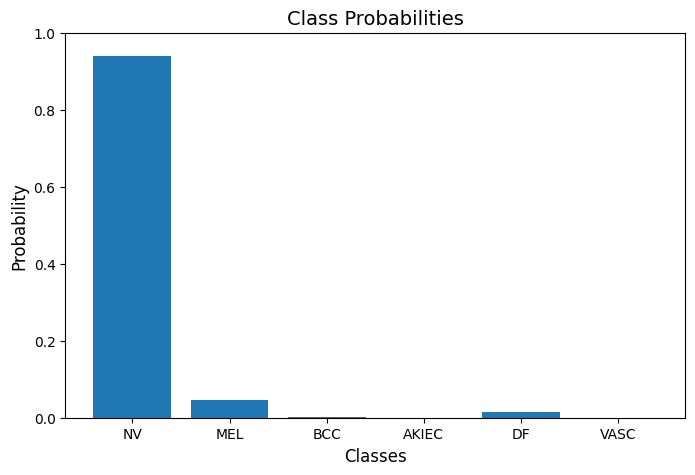

Class Probabilities: tensor([[9.3984e-01, 4.4812e-02, 8.8305e-04, 5.8674e-05, 1.4407e-02, 3.9442e-06]])
Uncertainty (Entropy): tensor([0.2654])


In [5]:
import matplotlib.pyplot as plt

def calculate_entropy(probs):
    """Compute entropy for a probability distribution."""
    return -torch.sum(probs * torch.log(probs + 1e-8), dim=1)  # Add epsilon for numerical stability


def preprocess_image(image_path):
    """Preprocess image for MobileNetV3."""
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalization for ImageNet
    ])
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)  # Add batch dimension

# Predict and calculate uncertainty
def predict_with_uncertainty(model, image_path):
    """Get class probabilities and uncertainty scores for an image."""
    image_tensor = preprocess_image(image_path)

    with torch.no_grad():
        probs = model(image_tensor)
        entropy = calculate_entropy(probs)

    labels = ['NV', 'MEL', 'BCC', 'AKIEC', 'DF', 'VASC']

    # Plot
    plt.figure(figsize=(8, 5))
    plt.bar(labels, probs.squeeze().tolist())
    plt.xlabel('Classes', fontsize=12)
    plt.ylabel('Probability', fontsize=12)
    plt.title('Class Probabilities', fontsize=14)
    plt.ylim(0, 1.0)  # Set y-axis limits for better visibility
    plt.show()


    return probs, entropy

image_path = "/content/drive/My Drive/ai&vis/images_subset_large/ISIC_0024369.jpg"
probs, entropy = predict_with_uncertainty(model, image_path)
print("Class Probabilities:", probs)
print("Uncertainty (Entropy):", entropy)



In [6]:
folder_path = "/content/drive/My Drive/ai&vis/images_subset_large/"
image_extensions = {'.jpg'}

labels = ['NV', 'MEL', 'BCC', 'AKIEC', 'DF', 'VASC']
NV_ent = []
MEL_ent = []
BCC_ent = []
AKIEC_ent = []
DF_ent = []
VASC_ent = []

def predict_with_uncert(model, image_path):
    """Get class probabilities and uncertainty scores for an image."""
    image_tensor = preprocess_image(image_path)

    with torch.no_grad():
        probs = model(image_tensor)
        entropy = calculate_entropy(probs)

    labels = ['NV', 'MEL', 'BCC', 'AKIEC', 'DF', 'VASC']


    return probs, entropy

for file_name in os.listdir(folder_path):
    file_path = os.path.join(folder_path, file_name)
    #print(file_path)

    # Check if the file is an image
    if os.path.isfile(file_path) and os.path.splitext(file_name)[1].lower() in image_extensions:
        # Call the function for the image
        probs, entropy = predict_with_uncert(model, file_path)
        max_index = torch.argmax(probs, dim=1).item()
        #print(probs)
        #print(max_index)

        # Get the label corresponding to the highest value
        max_label = labels[max_index]

        if max_label == labels[0]:
          NV_ent.append(entropy.item())
        if max_label == labels[1]:
          MEL_ent.append(entropy.item())
        if max_label == labels[2]:
          BCC_ent.append(entropy.item())
        if max_label == labels[3]:
          AKIEC_ent.append(entropy.item())
        if max_label == labels[4]:
          DF_ent.append(entropy.item())
        if max_label == labels[5]:
          VASC_ent.append(entropy.item())


NV_entropy = np.mean(NV_ent)
MEL_entropy = np.mean(MEL_ent)
BCC_entropy = np.mean(BCC_ent)
AKIEC_entropy = np.mean(AKIEC_ent)
DF_entropy = np.mean(DF_ent)
VASC_entropy = np.mean(VASC_ent)

print(f"NV Entropy:{NV_entropy}, Nr. of classified images: {len(NV_ent)}")
print(f"MEL Entropy:{MEL_entropy}, Nr. of classified images: {len(MEL_ent)}")
print(f"BCC Entropy:{BCC_entropy}, Nr. of classified images: {len(BCC_ent)}")
print(f"AKIEC Entropy:{AKIEC_entropy}, Nr. of classified images: {len(AKIEC_ent)}")
print(f"DF Entropy:{DF_entropy}, Nr. of classified images: {len(DF_ent)}")
print(f"VASC Entropy:{VASC_entropy}, Nr. of classified images: {len(VASC_ent)}")


NV Entropy:0.024279143558237973, Nr. of classified images: 329
MEL Entropy:0.12191519424381944, Nr. of classified images: 112
BCC Entropy:0.019411060420647937, Nr. of classified images: 45
AKIEC Entropy:0.11422333692796138, Nr. of classified images: 45
DF Entropy:0.08431304442114486, Nr. of classified images: 9
VASC Entropy:0.0005156085113262287, Nr. of classified images: 10
